
# Exploratory Analysis of Architectural Ratings

This notebook documents the analysis pipeline for the five rating items (*Hominess, Naturalness, Personalness, Beauty, Approachability*), including data preparation, exploratory checks, dimensionality reduction (PCA), and group comparisons by **Category**.




# Data Preparation

## Loading libraries

In [1]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load and inspect dataset

In [2]:
# load the data
file_path = "Data_exp1.xlsx"   # Update with the correct path if needed
df = pd.read_excel(file_path)
# quick check
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9833 entries, 0 to 9832
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ImageNumber      9833 non-null   int64 
 1   Dimension        9833 non-null   object
 2   PredHominess     9833 non-null   object
 3   Hominess         9833 non-null   int64 
 4   Naturalness      9833 non-null   int64 
 5   Personalness     9833 non-null   int64 
 6   Beauty           9833 non-null   int64 
 7   Approachability  9833 non-null   int64 
 8   Participant      9833 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 691.5+ KB
None
   ImageNumber Dimension PredHominess  Hominess  Naturalness  Personalness  \
0           55   Ceiling         Plus         4            6             4   
1          138   Ceiling        Minus         3            5             1   
2          107  Lighting        Minus         2            3             1   
3           51   Ceiling      

We can see that this data frame has 9 variables. All of them are numerical except Dimension and PredHomines.

In [3]:
# check the size of the data frame
size_dim = df.shape
print(f"The size of this data frame: {size_dim}")
# check if there are missing values
missing_rows = df.isnull().any(axis=1).sum()
print(f"Number of rows with missing values: {missing_rows}")

The size of this data frame: (9833, 9)
Number of rows with missing values: 0


In [4]:
df['Participant'].value_counts()

Participant
32    160
2     160
34    160
35    160
36    160
     ... 
28    160
29    160
1     156
60    121
17    116
Name: count, Length: 62, dtype: int64

This data frame has 9833 rows without missing values. Most of the participants completed all 160 trials except number 60(121 trials) and 17(116 trials).

Each picture was categorized as either hominess Plus or hominess Negative. Within the Negative category, there were four subcategories: Ceiling, Lighting, Biophilic, and Combined. Each subcategory involved the removal of one dimension, except for the Combined condition, in which three dimensions were removed simultaneously. For analysis, we merged these conditions into a single categorical variable. Pictures labeled as hominess Plus were coded as Plus, whereas pictures labeled as hominess Negative were further classified according to their specific subcategory (Ceiling, Lighting, Biophilic, or Combined).

In [5]:
df['Category'] = np.where(df['PredHominess'] == 'Plus', 'Plus', df['Dimension'])
df['Category'].value_counts()

Category
Plus         4919
Combined     1233
Ceiling      1231
Lighting     1228
Biophilic    1222
Name: count, dtype: int64

# Exploratory analysis

## Distributions of rating variables

We can first check the statistics of the rating columns, then plot their distributions.

In [8]:
rating_cols = ['Hominess', 'Naturalness', 'Personalness', 'Beauty', 'Approachability']
rating_df = df[rating_cols]
# Summary statistics
print(rating_df.describe())

          Hominess  Naturalness  Personalness       Beauty  Approachability
count  9833.000000  9833.000000   9833.000000  9833.000000      9833.000000
mean      4.432320     4.226482      4.107495     4.867589         5.246415
std       1.798574     2.084627      1.925784     1.804851         1.711492
min       1.000000     1.000000      1.000000     1.000000         1.000000
25%       3.000000     2.000000      3.000000     4.000000         4.000000
50%       5.000000     5.000000      4.000000     5.000000         6.000000
75%       6.000000     6.000000      6.000000     6.000000         7.000000
max       7.000000     7.000000      7.000000     7.000000         7.000000


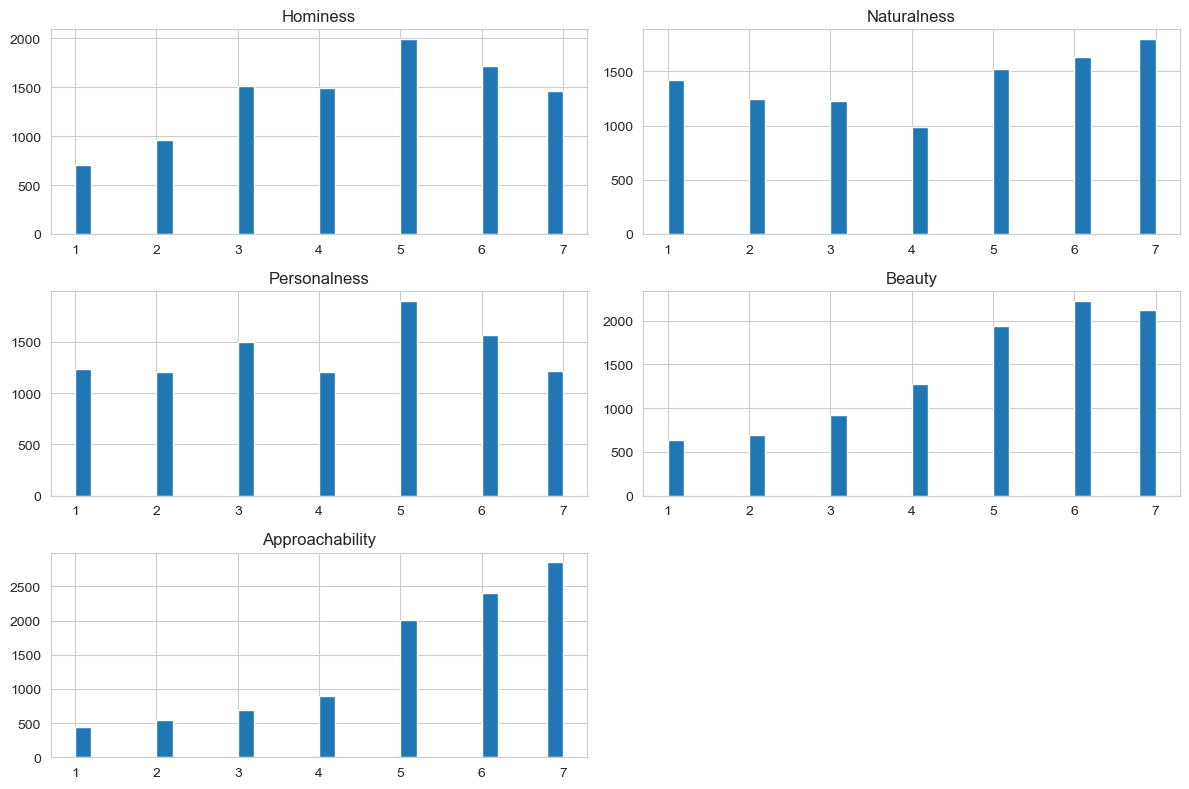

In [9]:
# Histograms
rating_df.hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

## Inter-variable correlations

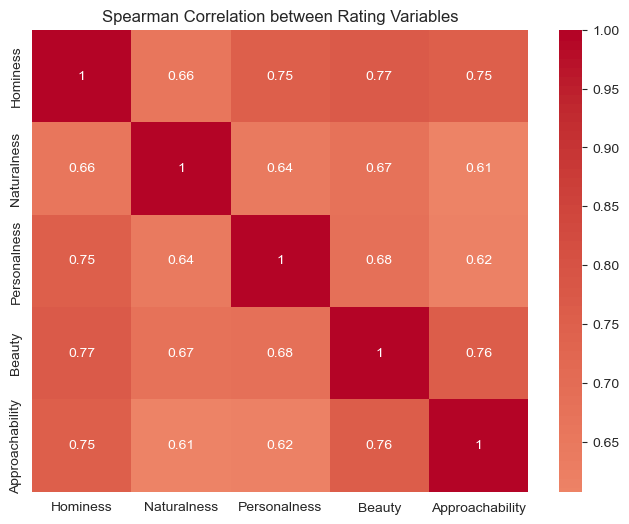

In [10]:
# Spearman correlation
corr = rating_df.corr(method="spearman")
# heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Spearman Correlation between Rating Variables")
plt.show()


The rating variables are highly correlated. So first we need to do dimension reduction. We are interested how many factors they are actually measuring.

## Consistency analysis (Cronbach's alpha)

In [11]:
import pingouin as pg
alpha = pg.cronbach_alpha(data=rating_df)
print("Cronbach’s alpha:", alpha)

Cronbach’s alpha: (0.9162247029571796, array([0.914, 0.919]))


The five rating items showed excellent internal consistency (Cronbach’s α = 0.92, 95% CI [0.914, 0.919]), suggesting that they reflect a common underlying construct.

# Dimensionality Reduction

In [13]:
# load libraries for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## PCA

In [14]:
# Standardize variables and run PCA
X_scaled = StandardScaler().fit_transform(rating_df)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
print("Explained variance ratio:", explained_var)
print("Cumulative explained variance:", cumulative_var)

Explained variance ratio: [0.75616507 0.08884057 0.07382676 0.04314609 0.03802152]
Cumulative explained variance: [0.75616507 0.84500563 0.9188324  0.96197848 1.        ]


### Scree plot

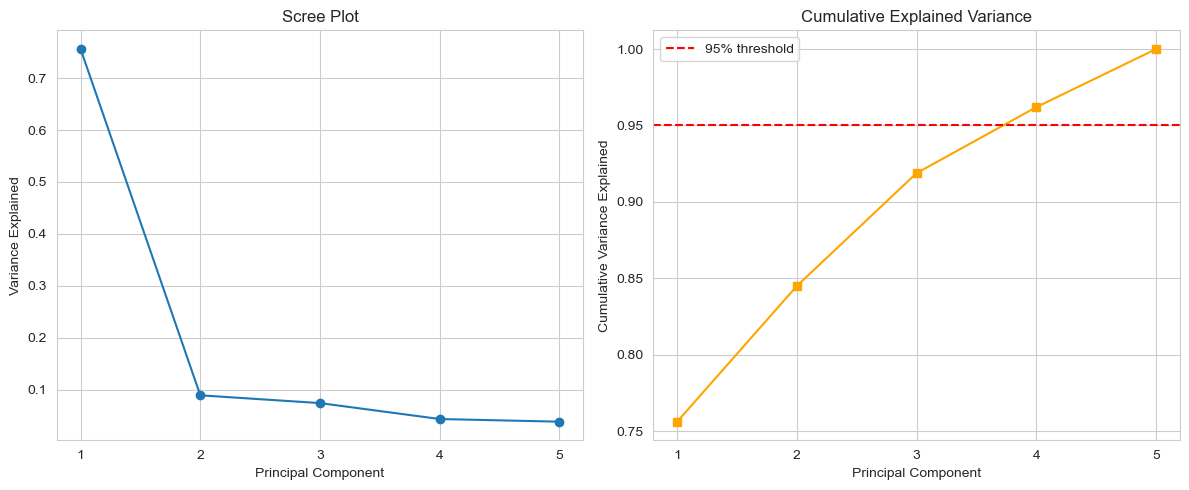

In [15]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --- Plot 1: Scree plot ---
axes[0].plot(range(1, len(explained_var)+1), explained_var, marker='o')
axes[0].set_xticks(np.arange(1, len(explained_var)+1, 1))
axes[0].set_xlabel("Principal Component")
axes[0].set_ylabel("Variance Explained")
axes[0].set_title("Scree Plot")

# --- Plot 2: Cumulative variance ---
axes[1].plot(range(1, len(cumulative_var)+1), cumulative_var, marker='s', color='orange')
axes[1].axhline(y=0.95, color='r', linestyle='--', label="95% threshold")
axes[1].set_xticks(np.arange(1, len(cumulative_var)+1, 1))
axes[1].set_xlabel("Principal Component")
axes[1].set_ylabel("Cumulative Variance Explained")
axes[1].set_title("Cumulative Explained Variance")
axes[1].legend()

plt.tight_layout()
plt.show()


Principal component analysis (PCA) revealed that the first component alone explained 75.6% of the variance, while the subsequent components each explained less than 10%. The scree plot suggested a clear one-factor solution. Together with the high internal consistency of the five items (Cronbach’s α = .92), this indicates that the ratings reflect a single underlying construct.

## Variable contributions

In [16]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=rating_df.columns
)

print(loadings)


                      PC1       PC2       PC3       PC4       PC5
Hominess         0.468545 -0.113248  0.243510 -0.549295  0.637666
Naturalness      0.419829  0.650195 -0.622114 -0.107838 -0.048331
Personalness     0.435904  0.391053  0.700963  0.175603 -0.367260
Beauty           0.462958 -0.291304 -0.148483  0.759567  0.319097
Approachability  0.447064 -0.571526 -0.200700 -0.280834 -0.595268


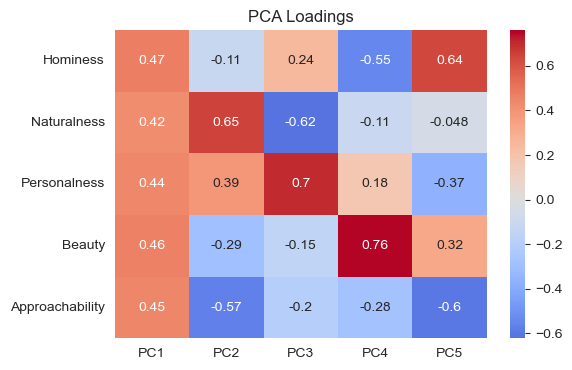

In [17]:
# plot the loadings
plt.figure(figsize=(6,4))
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Loadings")
plt.show()


All five items loaded strongly and positively on the first component (loadings ≈ .42–.47). Therefore, we can compute the mean values as the only depandent variable.

In [19]:
df['mean_rating'] = df[rating_cols].mean(axis=1)

# ANOVA

To test how the architectural factors affect our feeling about the rooms.

In [20]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('mean_rating ~ C(Category)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                   sum_sq      df            F  PR(>F)
C(Category)   9290.969080     4.0  1387.857075     0.0
Residual     16448.315493  9828.0          NaN     NaN


In [21]:
# Post hoc comparisions

from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['mean_rating'], groups=df['Category'], alpha=0.05)
print(tukey)


  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1   group2  meandiff p-adj  lower   upper  reject
--------------------------------------------------------
Biophilic  Ceiling   0.4963   0.0  0.3537  0.6388   True
Biophilic Combined   -1.453   0.0 -1.5955 -1.3105   True
Biophilic Lighting  -0.5381   0.0 -0.6807 -0.3954   True
Biophilic     Plus   1.2785   0.0  1.1657  1.3914   True
  Ceiling Combined  -1.9493   0.0 -2.0915 -1.8071   True
  Ceiling Lighting  -1.0343   0.0 -1.1767  -0.892   True
  Ceiling     Plus   0.7823   0.0  0.6698  0.8948   True
 Combined Lighting   0.9149   0.0  0.7727  1.0572   True
 Combined     Plus   2.7316   0.0  2.6191   2.844   True
 Lighting     Plus   1.8166   0.0   1.704  1.9292   True
--------------------------------------------------------


## Plots: mean ratings with 95% CI

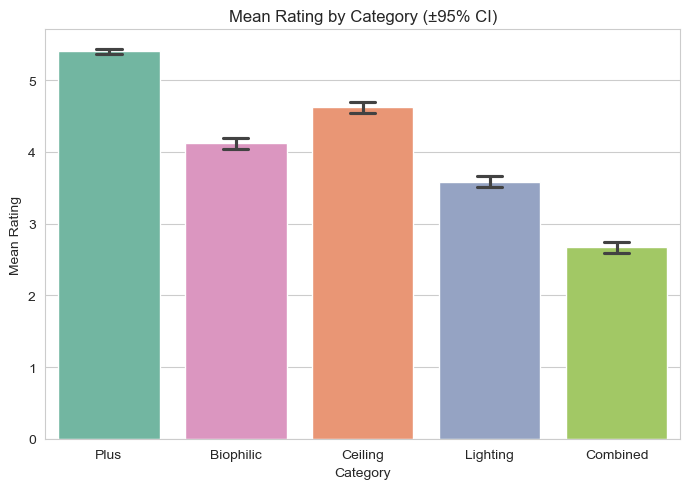

In [22]:
# --- Plot Category means with 95% CI ---

order = ["Plus", "Biophilic", "Ceiling", "Lighting", "Combined"]

plt.figure(figsize=(7,5))
sns.barplot(x="Category", y="mean_rating", hue="Category", data=df,
            order=order, palette="Set2", capsize=0.2, errorbar=('ci', 95), legend=False)
plt.ylabel("Mean Rating")
plt.xlabel("Category")
plt.title("Mean Rating by Category (±95% CI)")
plt.tight_layout()
plt.show()


We can observe the significant effect of category. As expected, participants rated the Plus images as the most homely and the Negative Combined images as the least homely. What's more interesting is the order of ratings after removing a certain dimension, i.e, Ceiling > Biophilic > Lighting, suggesting that the three factors make different contributions to the feeling of hominess.

# TBC